In [1]:
%matplotlib inline

In [14]:
import numpy as np
from itertools import permutations
from joblib import Parallel, delayed
import copy
from tqdm.auto import tqdm
import json
from time import sleep
import pandas as pd

In [3]:
import random                                                                     
import requests as rq                                                             
                                                                                  
# prepare request                                                                 
url = "http://challenge.calmcode.io/attempt/"                                     
emb = [random.random() for i in range(100)]                                       
# make request, remember to use your email!                                       
payload = {                                                                       
    "user": "baukebrenninkmeijer",                                      
    "email": 'bauke.brenninkmeijer@gmail.com',                                               
    "emb": emb                                                                    
}                                                                                 
resp = rq.post(url, json=payload)                                                 
                                                                                  
# read response                                                                   
print(resp.json())                                                             
  

{'distance': 114.1287696370119, 'datetime': '2020-06-16 13:44:59.042882', 'user': 'baukebrenninkmeijer', 'id': 'c37d68a2-a867-4b0a-81b0-9aeeb909a206'}


In [4]:
def score(vector):
    payload = {                                                                       
        "user": "baukebrenninkmeijer",                                      
        "email": "bauke.brenninkmeijer@gmail.com",                                               
        "emb": vector.tolist()                                                                    
    }
    try:
        resp = rq.post(url, json=payload, timeout=3).json()                                               
        return resp
    except:
        return None

In [70]:
class Numbers:
    def __init__(self, values=None, mean_n=5):
        self.values = np.random.randn(100) if values is None else values
        self.responses = []
        self.mean_n = mean_n
        self.mean_loss = None
        self.min_loss = None
        self.loss = None
        
    def score(self, swarm):
        payload = {                                                                       
            "user": "baukebrenninkmeijer",                                      
            "email": "bauke.brenninkmeijer@gmail.com",                                               
            "emb": self.values.tolist()                                                                   
        }
        loss = []
        for i in range(self.mean_n):
            try:
                resp = rq.post(url, json=payload, timeout=4).json()
                resp['values'] = self.values.tolist()
                self.responses.append(resp)
                resp['values'] = self.values.tolist()
                records.append(resp)
                loss.append(resp['distance'])
                swarmp.total_requests += 1
            except:
                pass
        sleep(0.02)
        losses = [i for i in loss if i is not None]
        try:
            self.mean_loss = np.mean(loss)
            self.min_loss = np.min(loss)
        except:
            self.mean_loss = np.inf
            self.min_loss = np.inf
        self.loss = self.min_loss
        
    def mutate(self, epoch=10):
#         np.arrange()
#         division = np.linspace(1, 10, 20)
        normal_ratio = 0.5
        finetune_ratio = 0.1
        self.values += (np.random.normal(size=100) * finetune_ratio)   

In [65]:
class Swarm:
    def __init__(self, pop_size=100, mean_n=5):
        self.pop_size = pop_size
        self.numbers = [Numbers(mean_n=mean_n) for _ in range(pop_size)]
        self.best = None
        self.topfive = None
        self.total_requests = 0
        
    def sort(self):
        self.numbers = sorted(self.numbers, key=lambda x: x.loss)

        
    def score(self):
        _ = Parallel(n_jobs=50, require='sharedmem')(delayed(lambda x: x.score(self))(i) for i in self.numbers)
        
    def selection(self):
        if self.topfive:
            self.numbers += copy.deepcopy(self.topfive)
        self.sort()
        self.numbers = self.numbers[:self.pop_size]
        if self.best is None or self.numbers[0].loss < self.best.loss:
            print(f'New Best!! Loss: {self.numbers[0].loss}')
            self.best = copy.deepcopy(self.numbers[0])
        else:
            self.numbers += [copy.deepcopy(self.best)]
        self.topfive = [copy.deepcopy(i) for i in self.numbers[:5]]
        
    def mutation(self, epoch=10):
        for individual in self.numbers:
            individual.mutate(epoch=epoch)
        
    def cross_over_individuals(self, i, j):
        self.numbers.append(Numbers(values=np.concatenate([i.values[:50], j.values[50:]])))
            
    def cross_over(self, n=10):
        new_numbers = []
        for i, j in permutations(self.numbers[:n], 2):
            self.cross_over_individuals(i, j)
        
        
    def top_n(self, n=5, t=None, epoch=None):
        b = f'{epoch}. ' if epoch else ""
        print(f'{b}Best: mean loss: {self.best.mean_loss}\tmin loss: {self.best.min_loss}')
        if t:
            t.set_postfix(mean_loss=self.best.mean_loss, min_loss=self.best.min_loss)
        for a, i in enumerate(self.numbers[:n]):
            print(f'{a}. Loss: {i.min_loss}')
            
    def forward(self, t, epoch=10):
        self.cross_over()
        self.mutation(epoch=epoch)
        self.score()
        self.selection()
        self.top_n(2, t, epoch)

    def save(self):
        file = 'records-minimum-non-reduced.json'
        json.dump(records, open(file, 'w'))

In [11]:
def optimize_swarm(steps=100, pop=100):
    swarm = Swarm(pop_size=pop, mean_n=3)
    swarm.score()
    swarm.selection()
    swarm.top_n(3)
    t = tqdm(range(steps))
    for a in t:
        swarm.forward(t, epoch=a)
    swarm.top_n(5)
    swarm.save()

In [ ]:
records = []
optimize_swarm(steps=1000, pop=30)

New Best!! Loss: 106.01219053224942
Best: mean loss: 114.59085258348809	min loss: 106.01219053224942
0. Loss: 106.01219053224942
1. Loss: 107.61289245641017
2. Loss: 107.65874885344519


New Best!! Loss: 103.31099732648218
Best: mean loss: 114.20741237090651	min loss: 103.31099732648218
New Best!! Loss: 102.41723506881085
Best: mean loss: 109.1955691767499	min loss: 102.41723506881085
New Best!! Loss: 100.73844554747616
Best: mean loss: 113.02628313636123	min loss: 100.73844554747616
New Best!! Loss: 100.12861839367757
Best: mean loss: 111.54143756501723	min loss: 100.12861839367757
New Best!! Loss: 100.08577344538854
Best: mean loss: 115.1548637730771	min loss: 100.08577344538854
New Best!! Loss: 99.13955056724744
Best: mean loss: 105.20925375398808	min loss: 99.13955056724744
New Best!! Loss: 98.33040886386604
Best: mean loss: 110.34236988579683	min loss: 98.33040886386604
New Best!! Loss: 97.25072896301204
Best: mean loss: 110.30014740298898	min loss: 97.25072896301204
New Best!! Loss: 96.5151779886197
Best: mean loss: 113.74311272851419	min loss: 96.5151779886197
New Best!! Loss: 96.03476443120435
Best: mean loss: 103.00276941844595	min loss: 96.03476443120435
New 

C:\Users\BaukeBrenninkmeijer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\BaukeBrenninkmeijer\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min loss: 28.021917766862217
Best: mean loss: 40.41660675430139	min l

In [15]:
df = pd.DataFrame(records)

In [17]:
df.to_csv('responses-loss-28.csv', index=False)

In [19]:
df.to_parquet('responses-loss-28.parquet', index=False)

In [20]:
read = pd.read_parquet('responses-loss-28.parquet')

C:\Users\BaukeBrenninkmeijer\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


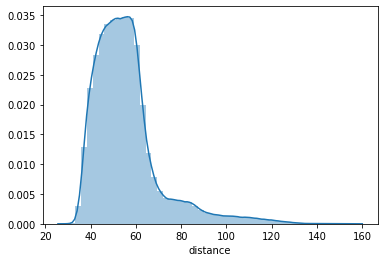

In [75]:
sns.distplot(read.distance)

In [21]:
len(read)

601518

In [31]:
values = read['values'].values

In [40]:
values_array = np.array(values.tolist())

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(2)

In [41]:
values_transformed = pca.fit_transform(values_array)

In [42]:
import seaborn as sns

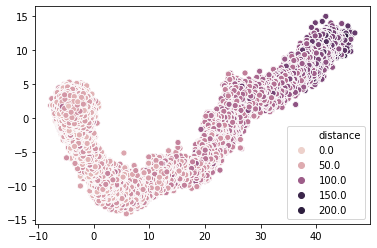

In [44]:
sns.scatterplot(x=values_transformed[:, 0], y=values_transformed[:, 1], hue=read.distance)

In [55]:
sorted_distance = read.sort_values('distance')
sorted_values_array = np.array(sorted_distance['values'].values.tolist())

In [51]:
sorted_distance.iloc[0, 4]

array([ -3.97835845,  -1.51316637,   4.98241666,   5.98818592,
        -5.47654081,  -2.63816214,  -2.21270478,   1.58132301,
        -9.1722771 ,   0.68501334,   8.52731414,   2.04617279,
        -2.57349402,   9.98304391,   6.02181061,  -5.41039369,
        -6.94173508,   4.35223232,   7.05604281,  -0.44162546,
         1.39812707,  -1.39672211,  -2.8450654 ,  -2.22964732,
        -1.15803658,  -5.15166674,   7.73630462,  -2.43851939,
         2.68336598,  -8.6793953 ,   2.64574527,   1.609597  ,
        -5.42742301,  -5.00596533,   4.57460375,  -1.99585207,
         2.23740777,   3.07359306,   8.06272955,  -1.86559795,
        -3.78741024,  -0.45536007,  -6.93370187,  -5.14193382,
         6.7301577 ,  -7.15032679,  -0.19934026,  -9.75251403,
        -1.42310352,   5.99545586,   8.60429599,   4.53981195,
         3.23427557,  -4.26329746,   4.01009154,  -9.2856399 ,
        -3.48281   ,  -2.0499739 ,  -6.52365207,  -7.23614135,
         8.66691818,   4.2810518 ,  -3.24387138,   6.38

### Write top requests to TSVs for embedding projector

In [56]:
pd.DataFrame(sorted_values_array)[:5000].to_csv('values.tsv', index=False, header=False, sep='\t')

In [57]:
sorted_distance.drop(['values'], axis=1)[:5000].to_csv('metadata.tsv', index=False, sep='\t')

### Finetune

In [73]:
swarm = Swarm(pop_size=40, mean_n=3)
top_numbers = [Numbers(values=x) for x in sorted_values_array[:15]]
swarm.numbers = top_numbers

In [74]:
steps = 150
finetune_records = []

swarm.score()
swarm.selection()
swarm.top_n(3)
t = tqdm(range(steps))
for a in t:
    swarm.forward(t, epoch=a)
swarm.top_n(5)
# swarm.save()

New Best!! Loss: 38.52802962954307
Best: mean loss: 62.70554754725496	min loss: 38.52802962954307
0. Loss: 38.52802962954307
1. Loss: 39.46052082270233
2. Loss: 41.39229266114909


New Best!! Loss: 29.73830057173109
Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 36.52100667128879
1. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 32.191492481616635
2. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 32.191492481616635
3. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 32.191492481616635
4. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 32.191492481616635
5. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 31.088157648375436
6. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 31.088157648375436
7. Best: mean loss: 48.482652510561046	min loss: 29.73830057173109
0. Loss: 29.73830057173109
1. Loss: 31.088157648